In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
import sklearn
from snakemake.io import expand

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from proc_revisions.utils import *
from proc_revisions.plotting import *

In [2]:
od = '../../proc_revisions/'
config_file = f'{od}/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [3]:
obs_col = 'sample'


In [4]:
# ics = od+expand(config['lr']['cerberus']['ics'], species='human')[0]
# ics = od+expand(config['lr']['talon']['ics'], species='human')[0]
talon_gtf = od+expand(config['lr']['talon']['gtf'], species='human')[0]
talon_filt_ab = od+expand(config['lr']['talon']['filt_ab'], species='human')[0]
ref_gtf = od+expand(config['ref']['gtf'], species='human')[0]
ref_ics = od+expand(config['ref']['cerberus']['ics'], species='human')[0]


In [5]:
def add_ss_type_to_intron(df):
    """
    Given a bed-style df, add "ss_3" and "ss_5" columns to 
    indicate which splice site each coordinate is used
    
    Parameters:
        df (pandas DataFrame): Bed-style DF of introns
    
    Returns:
        df (pandas DataFrame): Bed-style DF of introns w/ ss_3 and ss_5 columns added
    """
    
    df['ss_5'] = np.nan
    df.loc[df.Strand=='+', 'ss_5'] = df.loc[df.Strand=='+', ['Start', 'End']].min(axis=1)
    df.loc[df.Strand=='-', 'ss_5'] = df.loc[df.Strand=='-', ['Start', 'End']].max(axis=1)
    
    df['ss_3'] = np.nan
    df.loc[df.Strand=='+', 'ss_3'] = df.loc[df.Strand=='+', ['Start', 'End']].max(axis=1)
    df.loc[df.Strand=='-', 'ss_3'] = df.loc[df.Strand=='-', ['Start', 'End']].min(axis=1)
        
    assert len(df.loc[(df.ss_3<df.ss_5)&(df.Strand=='+')].index) == 0
    assert len(df.loc[(df.ss_3>df.ss_5)&(df.Strand=='-')].index) == 0
    
    return df
    

def intron_to_ss(df, id_cols=None):
    """
    Get splice site coordinates from intron coordinates in bed format
    
    Parameters:
        df (pandas DataFrame): Pandas DF of intron coordinates in bed format
        id_cols (None or list of str): List of columns to use as ss identifier 
            during melt, otherwise None
            
    Returns:
        df (pandas DataFrame): Pandas DF of splice site coordinates in semi 
            bed format (ie no end positions, just starts, as these are single bp)
    """
    
    
    # since these are intron coords, the start defines a 3' ss 
    # and the end defines a 5' ss.
    # df.rename({'Start':'ss_3', 'End':'ss_5'}, axis=1, inplace=True)
#     df['ss_5'] = np.nan
#     df.loc[df.Strand=='+', 'ss_5'] = df.loc[df.Strand=='+', ['Start', 'End']].min(axis=1)
#     df.loc[df.Strand=='-', 'ss_5'] = df.loc[df.Strand=='-', ['Start', 'End']].max(axis=1)
    
#     df['ss_3'] = np.nan
#     df.loc[df.Strand=='+', 'ss_3'] = df.loc[df.Strand=='+', ['Start', 'End']].max(axis=1)
#     df.loc[df.Strand=='-', 'ss_3'] = df.loc[df.Strand=='-', ['Start', 'End']].min(axis=1)
        
    df = add_ss_type_to_intron(df)
    
    assert len(df.loc[(df.ss_3<df.ss_5)&(df.Strand=='+')].index) == 0
    assert len(df.loc[(df.ss_3>df.ss_5)&(df.Strand=='-')].index) == 0
    
    df.drop(['Start', 'End'], axis=1, inplace=True)
    
    if id_cols:
        id_cols += ['Chromosome', 'Strand']
    else:
        id_cols = ['Chromosome', 'Strand']
        
    df = df.melt(id_vars=id_cols,
                 var_name='ss_type',
                 value_name='Start')
    
    # remove duplicates, which would result from the same 
    # ss being used in different sjs
    df = df.drop_duplicates()

    return df
        
def get_source_table(df):
    """
    Get a melted form table for each entry in a tss, ic, or tes table
    for each form of support for each triplet feature.
    
    Parameters:
        df (pandas DataFrame): DataFrame of tsss, ics, or tess
    
    Returns:
        df (pandas DataFrame): Long-form DataFrame of support for each tss, ic, or tes
    """
    keep_cols = ['Name', 'source']
    df = df[keep_cols].copy(deep=True)
    df['list_source'] = df.source.str.split(',')
    df = df.explode('list_source')
    df.drop('source', axis=1, inplace=True)
    
    return df

# chatgpt wrote this for me thanx chatgpt
def sequential_pairs(x, how='sj'):
    """
    Get sequential pairs of tuples in list.
    Example: [1,2,3,4] -> [(1,2),(3,4)]
    """
    p = []
    if how == 'sj' or how == 'ss':
        for i in range(0, len(x) - 1, 2):
            p.append((x[i], x[i + 1]))
    elif how == 'exon':
        for i in range(1, len(x) - 1, 2):
            p.append((x[i], x[i + 1]))
    return p

def explode_ic(ic, how):
    """
    Explode an ic df to long form with splice junction entries
    """
    # remove the monoexonic entries    
    ic = ic.loc[~(ic.Coordinates == '-')]
        
    # remove the two-exon entries if we're getting exons
    if how == 'exon':
        ic = ic.loc[~(ic.Coordinates.str.count('-')==1)]
    
    # explode into series of ss coords
    keep_cols = ['Chromosome', 'Coordinates',
                 'Strand', 'gene_id',
                 'Name']
    df = ic.copy(deep=True)
    df = df[keep_cols]
    df['ss_coords'] = df.Coordinates.str.split('-')
    
    # get pairs of sss to form sjs
    df['sj_coords'] = df.ss_coords.apply(sequential_pairs, how=how)
    df = df.explode('sj_coords')
    df.drop(['Coordinates', 'ss_coords'], axis=1, inplace=True)
                
    return df

def get_ss_sj_from_ic(ic, ref_sources, how):
    ic = ic.copy(deep=True)

    # get coords of each splice site in each splice junction
    df = explode_ic(ic, how=how)
    df['Start'] = df['sj_coords'].str[0].astype(int)
    df['End'] = df['sj_coords'].str[1].astype(int)
    df.drop('sj_coords', axis=1, inplace=True)

    # label sss as 5' or 3' and melt
    if how == 'ss':
        # assert len(df.loc[(df.Start>df.End)&(df.Strand=='+')].index) == 0
        # # since these are intron coords, the start defines a 3' ss 
        # # and the end defines a 5' ss
        # df.rename({'Start':'ss_3', 'End':'ss_5'}, axis=1, inplace=True)
        # id_cols = ['Chromosome', 'Strand', 'gene_id', 'Name']
        # df = df.melt(id_vars=id_cols,
        #              var_name='ss_type',
        #              value_name='Start')
        df = intron_to_ss(df, ['gene_id', 'Name'])
        
    # for sjs, reorder according to min and max coords
    # in bed standard format
    elif how == 'sj' or how == 'exon':
        df['temp_Start'] = df.Start
        df['temp_End'] = df.End
        df['Start'] = df[['temp_Start', 'temp_End']].min(axis=1)
        df['End'] = df[['temp_Start', 'temp_End']].max(axis=1)
        df.drop(['temp_Start', 'temp_End'], axis=1, inplace=True)
             
    # df to hold ic to ss or sj info 
    ic_df = df.copy(deep=True)
    
    # merge source info in w/ coord info
    df2 = get_source_table(ic)
    df = df.merge(df2, how='left', on=['Name'])
    
    # figure out novelty and source of each ss / sj
    df.drop('Name', axis=1, inplace=True)
    df.drop_duplicates(inplace=True)
    gb_cols = ['Chromosome', 'Strand', 'gene_id', 'Start']
    if how == 'ss':
        gb_cols += ['ss_type']
    elif how == 'sj' or how == 'exon':
        gb_cols += ['End']
    df.rename({'list_source': 'source'},
              axis=1, inplace=True)
    df['novelty'] = df.source.isin(ref_sources).map({True: 'Known',
                                                     False: 'Novel'})
    df = df.groupby(gb_cols).agg(','.join).reset_index()
    df = cerberus.update_novelty(df)
    
    # add novelty and support information to the ic / (ss or sj) df
    merge_cols = ['Chromosome', 'Strand', 'gene_id', 'Start']
    if how == 'ss':
        merge_cols += ['ss_type']
    elif how == 'sj' or how == 'exon':
        merge_cols += ['End']
    ic_df = ic_df.merge(df, how='left',
                        on=merge_cols)
    
    return df, ic_df

def get_exon_from_ic(ic, ref_sources):
    """
    Get a splice junction table from an intron chain table.
    Retain source and novelty information.
    
    Parameters:
        ic (pandas DataFrame): DataFrame formatted as cerberus ic table
        ref_sources (list of str): List of sources to use as references
        
    Returns:
        df (pandas DataFrame): DataFrame with entries for each splice junction
        ic_df (pandas DataFrame): DataFrame with entries for each splice junction /
            intron chain combination
        
    """
    return get_ss_sj_from_ic(ic, ref_sources, 'exon')


def get_sj_from_ic(ic, ref_sources):
    """
    Get a splice junction table from an intron chain table.
    Retain source and novelty information.
    
    Parameters:
        ic (pandas DataFrame): DataFrame formatted as cerberus ic table
        ref_sources (list of str): List of sources to use as references
        
    Returns:
        df (pandas DataFrame): DataFrame with entries for each splice junction
        ic_df (pandas DataFrame): DataFrame with entries for each splice junction /
            intron chain combination
        
    """
    return get_ss_sj_from_ic(ic, ref_sources, 'sj')

def get_ss_from_ic(ic, ref_sources):
    """
    Get a splice site table from an intron chain table.
    Retain source and novelty information.
    
    Parameters:
        ic (pandas DataFrame): DataFrame formatted as cerberus ic table
        ref_sources (list of str): List of sources to use as references
        
    Returns:
        df (pandas DataFrame): DataFrame with entries for each splice site
        ic_df (pandas DataFrame): DataFrame with entries for each splice site /
            intron chain combination
    """
    return get_ss_sj_from_ic(ic, ref_sources, 'ss')       

In [6]:
def get_fusion_sj_table(ab, ics, ref_ics, ver, include_novel=True):
    gtf_df, _, _ = get_gtf_info(ver=ver, how='gene', add_stable_gid=True)
    gtf_df = gtf_df[['gid_stable', 'gname']]
    gtf_df.head()
    
    talon_df = pd.read_csv(talon_filt_ab, sep='\t')
    talon_df['gid'] = cerberus.get_stable_gid(talon_df, 'annot_gene_id')
    
    fusion_gids = talon_df.loc[talon_df.gene_novelty=='Fusion', 'gid'].tolist()
    known_gids = talon_df.loc[talon_df.gene_novelty=='Known', 'gid'].tolist()
    
    df = pd.read_csv(ics, sep='\t')
    df['gene_id'] = df.Name.str.split('_', expand=True)[0]
    df['source'] = 'lapa'
    
    fusion_df = df.loc[df.gene_id.isin(fusion_gids)].copy(deep=True)    
    # known_df = df.loc[df.gene_id.isin(known_gids)]    
    known_df = pd.read_csv(ref_ics, sep='\t')
    known_df['gene_id'] = known_df.Name.str.split('_', expand=True)[0]
    known_df['source'] = 'lapa'
    
    _, f_sj_ic_df = get_sj_from_ic(fusion_df, ['lapa'])
    f_sj_ic_df.drop(['source', 'novelty'], axis=1, inplace=True)
    
    _, k_sj_ic_df = get_sj_from_ic(known_df, ['lapa'])
    k_sj_ic_df.drop(['source', 'novelty'], axis=1, inplace=True)
    
    f_sj_ic_df = f_sj_ic_df.merge(k_sj_ic_df, how='left', on=['Chromosome', 'Strand', 'Start', 'End'],
                              suffixes=('', '_known'))
    f_sj_ic_df['known'] = False
    f_sj_ic_df.loc[f_sj_ic_df.Name_known.notnull(), 'known'] = True
    
    # total # splice sjs / ic
    temp = f_sj_ic_df[['Name', 'Chromosome', 'Strand', 'Start', 'End']].copy(deep=True)
    temp['sj'] = temp.Name+temp.Chromosome+temp.Strand+temp.Start.astype(str)+temp.End.astype(str)
    temp = temp[['Name', 'sj']]
    temp = temp.groupby('Name').nunique().reset_index()
    temp.rename({'sj':'n_total_sj'}, axis=1, inplace=True)
    temp.head()
    
    # splice junctions / ic from each gene
    temp2 = f_sj_ic_df[['Name', 'known', 'Start', 'End', 'gene_id_known']].copy(deep=True)
    temp2.drop_duplicates(inplace=True)
    temp2.drop('End', axis=1, inplace=True)
    if include_novel == True:
        dropna = False
    else:
        dropna = True
    temp2 = temp2.groupby(['Name', 'known', 'gene_id_known'], dropna=dropna).count().reset_index()
    temp2.rename({'gene_id_known': 'gene_id', 'Start': 'n_sj'}, axis=1, inplace=True)
    temp2.head()

    # number each gene as 1' 2' or 3'
    temp2 = temp2.sort_values(by='n_sj', ascending=False)
    temp2['rank'] = temp2.sort_values(by='n_sj', ascending=False).groupby(['Name']).cumcount()+1
    temp2.head()
    
    # number of genes w/ intersecting sjs / ic
    temp3 = temp2[['Name', 'gene_id']].groupby('Name', dropna=dropna).nunique(dropna=dropna).reset_index()
    temp3.rename({'gene_id': 'n_genes'}, axis=1, inplace=True)
    temp3.head()
    
    temp5 = temp.merge(temp2, on='Name')
    temp5 = temp5.merge(temp3, on='Name')
    temp5['perc'] = (temp5['n_sj']/temp5['n_total_sj'])*100
    return f_sj_ic_df, temp5

In [7]:
def get_fusion_ss_table(ab, gtf, ref_ics, ver, include_novel=True):
    gtf_df, _, _ = get_gtf_info(ver=ver, how='gene', add_stable_gid=True)
    gtf_df = gtf_df[['gid_stable', 'gname']]
    gtf_df.head()
    
    talon_df = pd.read_csv(talon_filt_ab, sep='\t')
    talon_df['gid'] = cerberus.get_stable_gid(talon_df, 'annot_gene_id')
    
    fusion_gids = talon_df.loc[talon_df.gene_novelty=='Fusion', 'gid'].tolist()
    known_gids = talon_df.loc[talon_df.gene_novelty=='Known', 'gid'].tolist()
    
    # df = pd.read_csv(ics, sep='\t')
    # df['gene_id'] = df.Name.str.split('_', expand=True)[0]
    # df['source'] = 'lapa'
    df = pr.read_gtf(gtf, rename_attr=True, duplicate_attr=True)
    df = cerberus.get_ic(df)
    df.rename({'transcript_id':'Name', 'ic': 'Coordinates'}, axis=1, inplace=True)
    df['source'] = 'lapa'
    
    
    fusion_df = df.loc[df.gene_id.isin(fusion_gids)].copy(deep=True)    
    known_df = pd.read_csv(ref_ics, sep='\t')
    known_df['gene_id'] = known_df.Name.str.split('_', expand=True)[0]
    known_df['source'] = 'lapa'
    
    _, f_ss_ic_df = get_ss_from_ic(fusion_df, ['lapa'])
    f_ss_ic_df.drop(['source', 'novelty'], axis=1, inplace=True)
    
    _, k_ss_ic_df = get_ss_from_ic(known_df, ['lapa'])
    k_ss_ic_df.drop(['source', 'novelty'], axis=1, inplace=True)
    
    f_ss_ic_df = f_ss_ic_df.merge(k_ss_ic_df, how='left', on=['Chromosome', 'Strand', 'Start', 'ss_type'],
                              suffixes=('', '_known'))
    f_ss_ic_df['known'] = False
    f_ss_ic_df.loc[f_ss_ic_df.Name_known.notnull(), 'known'] = True
    
    # total # splice sss / ic
    temp = f_ss_ic_df[['Name', 'Chromosome', 'Strand', 'Start']].copy(deep=True)
    temp['ss'] = temp.Name+temp.Chromosome+temp.Strand+temp.Start.astype(str)
    temp = temp[['Name', 'ss']]
    temp = temp.groupby('Name').nunique().reset_index()
    temp.rename({'ss':'n_total_ss'}, axis=1, inplace=True)
    temp.head()
    
    # splice sites / ic from each gene
    temp2 = f_ss_ic_df[['Name', 'known', 'Start', 'gene_id_known']].copy(deep=True)
    temp2.drop_duplicates(inplace=True)
    if include_novel == True:
        dropna = False
    else:
        dropna = True
    temp2 = temp2.groupby(['Name', 'known', 'gene_id_known'], dropna=dropna).count().reset_index()
    temp2.rename({'gene_id_known': 'gene_id', 'Start': 'n_ss'}, axis=1, inplace=True)
    temp2.head()

    # number each gene as 1' 2' or 3'
    temp2 = temp2.sort_values(by='n_ss', ascending=False)
    temp2['rank'] = temp2.sort_values(by='n_ss', ascending=False).groupby(['Name']).cumcount()+1
    temp2.head()
    
    # number of genes w/ intersecting sss / ic
    temp3 = temp2[['Name', 'gene_id']].groupby('Name', dropna=dropna).nunique(dropna=dropna).reset_index()
    temp3.rename({'gene_id': 'n_genes'}, axis=1, inplace=True)
    temp3.head()
    
    temp5 = temp.merge(temp2, on='Name')
    temp5 = temp5.merge(temp3, on='Name')
    temp5['perc'] = (temp5['n_ss']/temp5['n_total_ss'])*100
    return f_ss_ic_df, temp5, fusion_df

In [8]:
include_novel=False
gtf_df, _, _ = get_gtf_info(ver='v40_cerberus', how='gene', add_stable_gid=True)
gtf_df = gtf_df[['gid_stable', 'gname']]
gtf_df.head()

talon_df = pd.read_csv(talon_filt_ab, sep='\t')
talon_df['gid'] = cerberus.get_stable_gid(talon_df, 'annot_gene_id')

tids = talon_df.loc[(talon_df.transcript_novelty!='Known')&(talon_df.gene_novelty=='Known'), 'annot_transcript_id'].tolist()

df = pr.read_gtf(talon_gtf, rename_attr=True, duplicate_attr=True)
df = cerberus.get_ic(df)
df.rename({'transcript_id':'Name', 'ic': 'Coordinates'}, axis=1, inplace=True)
df['source'] = 'lapa'

Found attributes with reserved names: ['source'].
Renaming attributes with suffix '_attr'


In [9]:
# get gids from annotated fusion genes
rt_df, _, _ = get_gtf_info(ver='v40_cerberus', how='iso')
rt_df = rt_df.loc[rt_df.readthrough_transcript==True]
rt_df['gid_stable'] = cerberus.get_stable_gid(rt_df, 'gid')
fusion_gids = rt_df.gid_stable.tolist()

In [10]:
known_df = pr.read_gtf(ref_gtf, rename_attr=True, duplicate_attr=True)
known_df = cerberus.get_ic(known_df)
known_df.rename({'transcript_id':'Name', 'ic': 'Coordinates'}, axis=1, inplace=True)
known_df['source'] = 'lapa'
known_df['gene_id'] = cerberus.get_stable_gid(known_df, 'gene_id')

In [11]:
_, f_ss_ic_df = get_ss_from_ic(df, ['lapa'])
f_ss_ic_df.drop(['source', 'novelty'], axis=1, inplace=True)

_, k_ss_ic_df = get_ss_from_ic(known_df, ['lapa'])
k_ss_ic_df.drop(['source', 'novelty'], axis=1, inplace=True)

In [12]:
f_ss_ic_df['ss_id'] = f_ss_ic_df.Name+f_ss_ic_df.Chromosome+f_ss_ic_df.Strand+f_ss_ic_df.Start.astype(str)+f_ss_ic_df.ss_type.astype(str)
k_ss_ic_df['ss_id'] = k_ss_ic_df.Name+k_ss_ic_df.Chromosome+k_ss_ic_df.Strand+k_ss_ic_df.Start.astype(str)+k_ss_ic_df.ss_type.astype(str)

In [13]:
f_ss_ic_df = f_ss_ic_df.merge(k_ss_ic_df, how='left', on=['Chromosome', 'Strand', 'Start', 'ss_type'],
                          suffixes=('', '_known'))
f_ss_ic_df['known'] = False
f_ss_ic_df.loc[f_ss_ic_df.Name_known.notnull(), 'known'] = True

In [14]:
f_ss_ic_df.loc[f_ss_ic_df.known==True].head()

,gene_id,Name,Chromosome,Strand,ss_type,Start,ss_id,gene_id_known,Name_known,ss_id_known,known
402,ENSG00000001460.17,ENST00000003583.12,chr1,-,ss_5,24413673.0,ENST00000003583.12chr1-24413673.0ss_5,ENSG00000001460,ENST00000003583.12,ENST00000003583.12chr1-24413673.0ss_5,True
403,ENSG00000001460.17,ENST00000003583.12,chr1,-,ss_5,24413673.0,ENST00000003583.12chr1-24413673.0ss_5,ENSG00000001460,ENST00000337248.8,ENST00000337248.8chr1-24413673.0ss_5,True
404,ENSG00000001460.17,ENST00000003583.12,chr1,-,ss_5,24413673.0,ENST00000003583.12chr1-24413673.0ss_5,ENSG00000001460,ENST00000468303.5,ENST00000468303.5chr1-24413673.0ss_5,True
405,ENSG00000001460.17,ENST00000003583.12,chr1,-,ss_5,24401318.0,ENST00000003583.12chr1-24401318.0ss_5,ENSG00000001460,ENST00000003583.12,ENST00000003583.12chr1-24401318.0ss_5,True
406,ENSG00000001460.17,ENST00000003583.12,chr1,-,ss_5,24401318.0,ENST00000003583.12chr1-24401318.0ss_5,ENSG00000001460,ENST00000337248.8,ENST00000337248.8chr1-24401318.0ss_5,True


In [15]:
# 1. get all transcript + gene combinations
df = f_ss_ic_df[['gene_id', 'Name', 'gene_id_known', 'known']].drop_duplicates().copy(deep=True)

In [16]:
# 2. compute number of splice sites / transcript
temp = f_ss_ic_df[['Name', 'ss_id']].groupby('Name').nunique()
temp = temp.reset_index().rename({'ss_id': 'n_ss'}, axis=1)
df = df.merge(temp, how='left', on='Name')

In [17]:
# 3. add in the novelty of the talon gene and transcript
df = df.merge(talon_df[['transcript_novelty', 'gene_novelty', 'annot_transcript_id']], 
              how='left', 
              left_on='Name',
              right_on='annot_transcript_id')
df.drop('annot_transcript_id', axis=1, inplace=True)

In [18]:
# 4. subset for novel transcripts that belong to annotated genes
df = df.loc[(df.transcript_novelty!='Known')&\
            (df.gene_novelty=='Known')]

In [19]:
# 5. get all transcripts that have >= 1 splice site shared w/ a readthrough gene
tids = df.loc[df.gene_id_known.isin(fusion_gids), 'Name'].unique().tolist()
df = df.loc[df.Name.isin(tids)]

In [20]:
# df

In [21]:
# 6. get how many unique genes share splice sites with this transcript
temp = df.loc[df.known==True].copy(deep=True)
temp = temp[['Name', 'gene_id_known']].groupby('Name').nunique().reset_index()
temp.rename({'gene_id_known': 'n_genes'}, axis=1, inplace=True)
df = df.merge(temp, how='left', on='Name')

In [22]:
# 7. get how many unique genes share splice sites with this transcript
temp = df.loc[df.known==True].copy(deep=True)
temp = temp.loc[~temp.gene_id_known.isin(fusion_gids)]
temp = temp[['Name', 'gene_id_known']].groupby('Name').nunique().reset_index()
temp.rename({'gene_id_known': 'n_genes_no_rt'}, axis=1, inplace=True)
df = df.merge(temp, how='left', on='Name')

In [23]:
# 8. limit to transcripts w/ n_genes_no_rt < n_genes
# and n_genes_no_rt == 1 (only one choice)
# where the gene that was merged with is the non-rt one
df = df.loc[(df.n_genes_no_rt==1)&(df.n_genes>df.n_genes_no_rt)]
df = df.loc[~df.gene_id_known.isin(fusion_gids)]
df.head()

,gene_id,Name,gene_id_known,known,n_ss,transcript_novelty,gene_novelty,n_genes,n_genes_no_rt
0,ENSG00000008128.22,TALONT000291637,ENSG00000008128,True,12,ISM,Known,2,1.0
2,ENSG00000008128.22,TALONT000291641,ENSG00000008128,True,12,ISM,Known,2,1.0
4,ENSG00000008128.22,TALONT000291742,ENSG00000008128,True,2,ISM,Known,2,1.0
6,ENSG00000008128.22,TALONT000292018,ENSG00000008128,True,6,ISM,Known,2,1.0
8,ENSG00000215790.7,TALONT000292468,ENSG00000215790,True,12,NNC,Known,2,1.0


In [24]:
# 9. get the number of splice sites supported by the transcript w/ the most
# shared splice sites for each transcript + annotated gene combination, 
# then merge in based on transcript from obs. transcripts
temp = f_ss_ic_df.copy(deep=True)
temp = temp[['Name', 'ss_id', 'gene_id_known', 'Name_known']].drop_duplicates()
temp = temp.groupby(['Name', 'gene_id_known', 'Name_known']).nunique().reset_index()
temp.rename({'ss_id': 'n_supp_ss',
             'Name_known': 'Name_supp'}, axis=1, inplace=True)
temp = temp.sort_values(by='n_supp_ss', ascending=False)
temp = temp.drop_duplicates(subset=['Name', 'gene_id_known'], keep='first')
df = df.merge(temp, how='left', on=['Name', 'gene_id_known'])

In [25]:
# 9.5. get the number of splice sites supported by the transcript w/ the most
# shared splice sites for each transcript + annotated gene combination, 
# then merge in based on transcript from obs. transcripts
temp = f_ss_ic_df.copy(deep=True)
temp = temp[['Name', 'ss_id', 'gene_id_known', 'Name_known']].drop_duplicates()
temp = temp.loc[temp.gene_id_known.isin(fusion_gids)]
temp = temp.groupby(['Name', 'gene_id_known', 'Name_known']).nunique().reset_index()
temp.rename({'ss_id': 'n_supp_ss_rt',
             'Name_known': 'Name_supp_rt',
             'gene_id_known': 'gene_id_known_rt'}, axis=1, inplace=True)
temp = temp.sort_values(by='n_supp_ss_rt', ascending=False)
temp = temp.drop_duplicates(subset=['Name'], keep='first')
df = df.merge(temp, how='left', on=['Name'])

In [26]:
# 10. remove entries where talon gene id is already
# the other choice
df['gid'] = cerberus.get_stable_gid(df, 'gene_id')
df = df.loc[df.gid!='gene_id_known']

In [27]:
# 11. get the total # of splice sites per annotated transcript
temp = k_ss_ic_df[['Name', 'ss_id']].groupby('Name').nunique().reset_index()
temp = temp.rename({'ss_id': 'n_supp_total_ss',
                                  'Name': 'Name_supp'}, axis=1)
df = df.merge(temp, how='left', on='Name_supp')
temp = temp.rename({'n_supp_total_ss': 'n_supp_total_ss_rt',
                    'Name_supp': 'Name_supp_rt'}, axis=1)
df = df.merge(temp, how='left', on='Name_supp_rt')

In [28]:
# 12. limit to obs. transcripts that were annotated to readthrough genes
df = df.loc[df.gid.isin(fusion_gids)]

In [29]:
len(df.index)

253

In [30]:
df['perc_supp_ss'] = (df.n_supp_ss/df.n_ss)*100
df['perc_supp_ss_rt'] = (df.n_supp_ss_rt/df.n_ss)*100
df['perc_supp_annot_ss'] = (df.n_supp_ss/df.n_supp_total_ss)*100
df['perc_supp_annot_ss_rt'] = (df.n_supp_ss_rt/df.n_supp_total_ss_rt)*100

In [31]:
# merge with my crummy annotations
temp = pd.read_csv('readthrough_genes_novel_transcripts_7.tsv', sep='\t')
temp = temp[['Name', 'does It need fix']]
temp.rename({'does It need fix': 'fix_needed'}, axis=1, inplace=True)
df = df.merge(temp, how='left', on='Name')
df.head()

,gene_id,Name,gene_id_known,known,n_ss,transcript_novelty,gene_novelty,n_genes,n_genes_no_rt,Name_supp,...,Name_supp_rt,n_supp_ss_rt,gid,n_supp_total_ss,n_supp_total_ss_rt,perc_supp_ss,perc_supp_ss_rt,perc_supp_annot_ss,perc_supp_annot_ss_rt,fix_needed
0,ENSG00000285641.1,TALONT001122495,ENSG00000143543,True,10,ISM,Known,3,1.0,ENST00000461365.1,...,ENST00000648869.1,6,ENSG00000285641,8.0,22,80.000000,60.000000,100.000000,27.272727,NaN
1,ENSG00000285641.1,TALONT001122495,ENSG00000143543,True,10,ISM,Known,3,1.0,ENST00000461365.1,...,ENST00000648869.1,6,ENSG00000285641,8.0,22,80.000000,60.000000,100.000000,27.272727,NaN
2,ENSG00000120948.17,TALONT000431066,ENSG00000277726,True,14,NIC,Known,2,1.0,ENST00000614757.4,...,ENST00000639599.1,11,ENSG00000120948,18.0,14,100.000000,78.571429,77.777778,78.571429,NaN
3,ENSG00000120948.17,TALONT000431076,ENSG00000277726,True,12,ISM,Known,2,1.0,ENST00000614757.4,...,ENST00000639599.1,11,ENSG00000120948,18.0,14,100.000000,91.666667,66.666667,78.571429,NaN
4,ENSG00000120948.17,TALONT000431147,ENSG00000277726,True,12,NIC,Known,2,1.0,ENST00000614757.4,...,ENST00000629725.2,11,ENSG00000120948,18.0,12,91.666667,91.666667,61.111111,91.666667,NaN


In [32]:
df['perc_supp_diff'] = df['perc_supp_ss']-df['perc_supp_ss_rt']
df['perc_supp_annot_diff'] = df['perc_supp_annot_ss']-df['perc_supp_annot_ss_rt']
df = df.loc[df.perc_supp_annot_ss.notnull()]
df.to_csv('readthrough_genes_novel_transcripts_9.tsv', sep='\t')

In [33]:
# 14. compute distances from transcript start and end to closest start and end from any transcript in

In [34]:
talon_df = pr.read_gtf(talon_gtf, rename_attr=True, duplicate_attr=True)
talon_df = talon_df.df
talon_df = talon_df.loc[talon_df.Feature=='transcript']

Found attributes with reserved names: ['source'].
Renaming attributes with suffix '_attr'


In [35]:
known_df = pr.read_gtf(ref_gtf, rename_attr=True, duplicate_attr=True)
known_df = known_df.df
known_df = known_df.loc[known_df.Feature=='transcript']

In [36]:
# talon_df['max_end'] = talon_df[['Start', 'End']].max(axis=1)
# talon_df['min_end'] = talon_df[['Start', 'End']].min(axis=1)

# known_df['max_end'] = known_df[['Start', 'End']].max(axis=1)
# known_df['min_end'] = known_df[['Start', 'End']].min(axis=1)

In [37]:
known_df['gene_id'] = cerberus.get_stable_gid(known_df, 'gene_id')

In [40]:
# add coords to novel thing (df)
temp = talon_df[['transcript_id', 'Start', 'End', 'Chromosome', 'Strand']]
temp.rename({'transcript_id':'Name'}, axis=1, inplace=True)
df = df.merge(temp, how='left', on='Name')
# df.columns

In [65]:
df = df.drop_duplicates()

In [66]:
# df.rename({'min_end':'Start', 'max_end':'End'}, axis=1, inplace=True)
# df.head()

In [67]:
# drop_cols = [c for c in df.columns if '_x' in c]
# drop_cols += [c for c in df.columns if '_y' in c]
# drop_cols += [c for c in df.columns if 'min_end' in c]
# drop_cols += [c for c in df.columns if 'max_end' in c]
# df.drop(drop_cols, axis=1, inplace=True)
# known_df.drop(drop_cols, axis=1, inplace=True)

In [73]:
temp3 = pd.DataFrame()
temp3['Name'] = df.Name.tolist()
for c in ['gene_id_known', 'gene_id_known_rt']:
    for feat in ['End', 'Start']:
        temp2 = pd.DataFrame() 
        for g in df[c].unique().tolist():
            if feat == 'Start':
                other_feat = 'End'
            elif feat == 'End':
                other_feat = 'Start'
            temp_nov = df.loc[df[c] == g].copy(deep=True)
            temp_nov = temp_nov[['Name', 'Chromosome', feat, 'Strand']]
            temp_nov[other_feat] = temp_nov[feat]+1 

            temp_known = known_df.loc[known_df.gene_id == g].copy(deep=True)
            temp_known = temp_known[['Chromosome', feat, 'Strand']]
            temp_known[other_feat] = temp_known[feat]+1 


            temp_nov = pr.PyRanges(temp_nov)
            temp_known = pr.PyRanges(temp_known)

            # pyranges join and get closest; concat in w/ temp2s
            temp_nov = temp_nov.k_nearest(temp_known, k=1, 
                               overlap=True,
                               how=None, suffix='_known').df
            temp_nov = temp_nov[['Name', 'Distance']].drop_duplicates()
            d_col = f'{c}_{feat}_dist'
            temp_nov.rename({'Distance': d_col}, axis=1, inplace=True)        
            # if len(temp_nov.loc[temp_nov[d_col].isnull()].index) > 0:
            #     import pdb; pdb.set_trace()
            temp2 = pd.concat([temp2, temp_nov], axis=0)
        temp3 = temp3.merge(temp2, on='Name', how='left')    

In [76]:
df = df.merge(temp3, how='left', on='Name')

In [251]:
# add abs. values
cols = ['gene_id_known_End_dist',
        'gene_id_known_Start_dist',
        'gene_id_known_rt_End_dist',
        'gene_id_known_rt_Start_dist']
for c in cols:
    new_col = f'{c}_abs'
    df[new_col] = df[c].abs()

In [252]:
df.to_csv('readthrough_genes_novel_transcripts_10.tsv', sep='\t')

## new predictor w/ the tss/tes distances as a metric

In [171]:
from sklearn.model_selection import KFold

In [172]:
df = pd.read_csv('readthrough_genes_novel_transcripts_9.tsv', sep='\t')
t_df = df.loc[df.fix_needed.isin(['yes', 'no'])]
pred_df = df.loc[~df.fix_needed.isin(['yes', 'no'])]
print(len(t_df.index))
print(len(pred_df.index))

43
175


In [173]:
# t_df.columns

In [174]:
feats = ['perc_supp_ss', 
         'perc_supp_ss_rt',
         'perc_supp_annot_ss',
         'perc_supp_annot_ss_rt',
         'gene_id_known_End_dist',
         'gene_id_known_Start_dist',
         'gene_id_known_rt_End_dist',
         'gene_id_known_rt_Start_dist']
label = 'fix_needed'
X = np.array(t_df[feats].values)
y_test = np.array(t_df[label])
print(X.shape)
print(y_test.shape)

(43, 8)
(43,)


In [182]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


# model = SVC()
model = DecisionTreeClassifier()
# model = RandomForestClassifier()
y_pred = cross_val_predict(model, X, y_test)

In [183]:
t_df['pred'] = y_pred

In [184]:
t_df[['Name', label]].groupby(label).count()

,Name
fix_needed,
no,6
yes,37


In [185]:
from sklearn.metrics import classification_report
print(classification_report(t_df[label].tolist(), y_pred, target_names=['yes', 'no']))

wrong_inds = [i for i in range(len(y_test)) if y_test[i] != y_pred[i]]
wrong_df = t_df.iloc[wrong_inds]

              precision    recall  f1-score   support

         yes       0.33      0.33      0.33         6
          no       0.89      0.89      0.89        37

    accuracy                           0.81        43
   macro avg       0.61      0.61      0.61        43
weighted avg       0.81      0.81      0.81        43



In [186]:
wrong_df.head()
# wrong_df.to_csv('wrong_preds_2.tsv', sep='\t')
# saving new wrong predictions as I refine my labels for the 
# training data
# wrong_df.to_csv('wrong_preds_3.tsv', sep='\t')
# wrong_df.to_csv('wrong_preds_4.tsv', sep='\t')
# wrong_df.to_csv('wrong_preds_5.tsv', sep='\t')
# wrong_df.to_csv('wrong_preds_7.tsv', sep='\t')

,Unnamed: 0,gene_id,Name,gene_id_known,known,n_ss,transcript_novelty,gene_novelty,n_genes,n_genes_no_rt,...,perc_supp_annot_diff,Start,End,Chromosome,Strand,gene_id_known_End_dist,gene_id_known_Start_dist,gene_id_known_rt_End_dist,gene_id_known_rt_Start_dist,pred
4,120,ENSG00000105501.12,TALONT001003889,ENSG00000268500,True,16,ISM,Known,2,1,...,4.861111,51611926,51630666,chr19,-,-16136,-164,-14881,0,yes
56,22,ENSG00000234857.2,TALONT000965659,ENSG00000214753,True,14,ISM,Known,2,1,...,23.411371,62721837,62727384,chr11,-,-90,-1026,2,31563,no
118,12,ENSG00000259030.7,TALONT000930071,ENSG00000116783,True,42,NIC,Known,2,1,...,-3.713768,74235400,74464925,chr1,+,-1378,0,-2,-37137,no
141,66,ENSG00000261832.6,TALONT000550296,ENSG00000188603,True,28,NIC,Known,2,1,...,5.833333,28477279,28492042,chr16,-,2,0,1,10450,no
197,151,ENSG00000284874.1,TALONT000347527,ENSG00000184702,True,16,NIC,Known,2,1,...,7.272727,19718468,19724772,chr22,+,-550,-11,-2,0,yes


## ok try to train this thing again cause apparently cross val predict doesn't return a model?

In [214]:
from sklearn.model_selection import train_test_split

In [215]:
feats = ['perc_supp_ss', 
         'perc_supp_ss_rt',
         'perc_supp_annot_ss',
         'perc_supp_annot_ss_rt',
         'gene_id_known_End_dist',
         'gene_id_known_Start_dist',
         'gene_id_known_rt_End_dist',
         'gene_id_known_rt_Start_dist']
label = 'fix_needed'
X = np.array(t_df[feats].values)
y = np.array(t_df[label])
print(X.shape)
print(y.shape)

(43, 8)
(43,)


In [221]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,
                                                    shuffle=True,
                                                    random_state=42)

In [222]:
model = DecisionTreeClassifier()

In [226]:
print('performance on training dataset')
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
report = classification_report(y_train, y_pred)
print("Classification Report:\n", report)

performance on training dataset
Classification Report:
               precision    recall  f1-score   support

          no       1.00      1.00      1.00         3
         yes       1.00      1.00      1.00        25

    accuracy                           1.00        28
   macro avg       1.00      1.00      1.00        28
weighted avg       1.00      1.00      1.00        28



In [227]:
print('performance on test dataset')
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

performance on test dataset
Classification Report:
               precision    recall  f1-score   support

          no       1.00      0.33      0.50         3
         yes       0.86      1.00      0.92        12

    accuracy                           0.87        15
   macro avg       0.93      0.67      0.71        15
weighted avg       0.89      0.87      0.84        15



In [228]:
print('performance on whole labelled dataset')
y_pred = model.predict(X)
report = classification_report(y, y_pred)
print("Classification Report:\n", report)

performance on whole labelled dataset
Classification Report:
               precision    recall  f1-score   support

          no       1.00      0.67      0.80         6
         yes       0.95      1.00      0.97        37

    accuracy                           0.95        43
   macro avg       0.97      0.83      0.89        43
weighted avg       0.96      0.95      0.95        43



In [230]:
wrong_inds = [i for i in range(len(y)) if y[i] != y_pred[i]]
wrong_df = t_df.iloc[wrong_inds]
wrong_df.to_csv('wrong_preds_8.tsv', sep='\t')

## apply above model, which I think is doing p good, to the data

In [233]:
from sklearn.model_selection import KFold
df = pd.read_csv('readthrough_genes_novel_transcripts_9.tsv', sep='\t')
p_df = df.loc[~df.fix_needed.isin(['yes', 'no'])]

In [234]:
feats = ['perc_supp_ss', 
         'perc_supp_ss_rt',
         'perc_supp_annot_ss',
         'perc_supp_annot_ss_rt',
         'gene_id_known_End_dist',
         'gene_id_known_Start_dist',
         'gene_id_known_rt_End_dist',
         'gene_id_known_rt_Start_dist']
label = 'fix_needed'
X = np.array(pred_df[feats].values)
y = np.array(pred_df[label])
print(X.shape)
print(y.shape)

(175, 8)
(175,)


In [235]:
y_pred = model.predict(X)

In [237]:
p_df['pred'] = y_pred

In [238]:
p_df.to_csv('predictions.tsv', sep='\t', index=False)

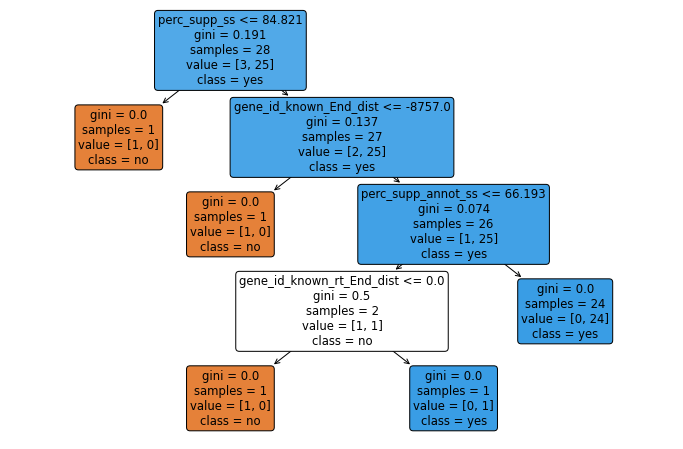

In [248]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

plt.figure(figsize=(12, 8))
plot_tree(model, filled=True, feature_names=feats, class_names=t_df[label].unique().tolist(), rounded=True)
plt.show()

In [243]:
from sklearn.datasets import load_iris
data = load_iris()
X_i = data.data
y_i = data.target

In [244]:
data.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [246]:
data.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

## try again but make a sum of abs. distances metric instead?

In [146]:
from sklearn.model_selection import KFold
df = pd.read_csv('readthrough_genes_novel_transcripts_9.tsv', sep='\t')
t_df = df.loc[df.fix_needed.isin(['yes', 'no'])]
t_df['gene_id_known_abs_dist'] = t_df.gene_id_known_End_dist.abs()+t_df.gene_id_known_Start_dist.abs()
t_df['gene_id_known_rt_abs_dist'] = t_df.gene_id_known_rt_End_dist.abs()+t_df.gene_id_known_rt_Start_dist.abs()
feats = ['perc_supp_ss', 
         'perc_supp_ss_rt',
         'perc_supp_annot_ss',
         'perc_supp_annot_ss_rt',
         'gene_id_known_abs_dist',
         'gene_id_known_rt_abs_dist']
         # 'gene_id_known_End_dist',
         # 'gene_id_known_Start_dist',
         # 'gene_id_known_rt_End_dist',
         # 'gene_id_known_rt_Start_dist']
t_df.head()
label = 'fix_needed'
X = np.array(t_df[feats].values)
y_test = np.array(t_df[label])
print(X.shape)
print(y_test.shape)

from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict
from sklearn.tree import DecisionTreeClassifier

# model = SVC()
model = DecisionTreeClassifier()
y_pred = cross_val_predict(model, X, y_test)
t_df['pred'] = y_pred
print(t_df[['Name', label]].groupby(label).count())

from sklearn.metrics import classification_report
print(classification_report(t_df[label].tolist(), y_pred, target_names=['yes', 'no']))

wrong_inds = [i for i in range(len(y_test)) if y_test[i] != y_pred[i]]
wrong_df = t_df.iloc[wrong_inds]

wrong_df.head()
# saving new wrong predictions as I refine my labels for the 
wrong_df.to_csv('wrong_preds_6.tsv', sep='\t')

(43, 6)
(43,)
            Name
fix_needed      
no             6
yes           37
              precision    recall  f1-score   support

         yes       0.29      0.33      0.31         6
          no       0.89      0.86      0.88        37

    accuracy                           0.79        43
   macro avg       0.59      0.60      0.59        43
weighted avg       0.80      0.79      0.80        43

